In [ ]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from pickle import load
from pickle import dump
from numpy.random import shuffle
import tensorflow as tf

In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def preprocess(text):
  text = ''.join(ch for ch in text if ch not in string.punctuation)
  text = text.lower()
  text = re.sub(r'\d','',text)
  text = re.sub(r'\s+',' ',text)
  text = text.strip()
  return text

In [ ]:
filepath="/content/drive/MyDrive/Data/english-hindi.pkl"

In [ ]:
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences(filepath)

# reduce dataset size
#n_sentences = raw_dataset.shape[0]
dataset = raw_dataset[:40000,]
print (len(dataset))
# random shuffle
shuffle(dataset)
# save
save_clean_data(dataset, 'english-hindi-both.pkl')

40000
Saved: english-hindi-both.pkl


In [ ]:
dataset[:2]

array([list(['18284', 'It extended at the same time support to the government in resisting the threatened American invasion ', 'साथ ही इसने सरकार को अमेरिका आक्रमण का मुकाबला करने के लिए भी अपना समर्थन दिया ']),
       list(['8521', 'Laughter', 'हंसी'])], dtype=object)

In [ ]:
dataset_list=(list(tuple(map(tuple, dataset))))

In [ ]:
english_sentences_list=[]
for T in dataset_list[:dataset.shape[0]]:
      english_sentences_list.append(T[1])

In [ ]:
hindi_sentences_list=[]
for T in dataset_list[:dataset.shape[0]]:
      hindi_sentences_list.append(T[-1])

In [ ]:
def preprocess(text):
  text = ''.join(ch for ch in text if ch not in string.punctuation)
  text = text.lower()
  text = re.sub(r'\d','',text)
  text = re.sub(r'\s+',' ',text)
  text = text.strip()
  return text

In [ ]:
english_sentences = [preprocess(en) for en in english_sentences_list]
hindi_sentences = ['<START> ' + re.sub('[a-zA-Z]','',preprocess(hi)) + ' <END>' for hi in hindi_sentences_list]

In [ ]:
print(len(english_sentences), len(hindi_sentences))
print("DATA TO START WITH")
english_sentences[:3], hindi_sentences[:3]

20000 20000
DATA TO START WITH


(['it extended at the same time support to the government in resisting the threatened american invasion',
  'laughter',
  'a uniform broad gauge all over the country would perhaps have been a luxury unwarranted by the nature and volume of the traffic at the time'],
 ['<START> साथ ही इसने सरकार को अमेरिका आक्रमण का मुकाबला करने के लिए भी अपना समर्थन दिया <END>',
  '<START> हंसी <END>',
  '<START> पूरे देश में एक समान बड़ी लाइन उस समय के वहन भार तथा वहन प्रकृति को देखते हुए एक विलासिता की बात ही बनती <END>'])

In [ ]:
vocab_size = 10000
total_sentences = 20000
maxlen = 10
epochs = 55
validation_split = 0.05

In [ ]:
en_data = []
hi_data = []

cnt = 0

for (en,hi) in zip(english_sentences, hindi_sentences):
  l = min(len(en.split()), len(hi.split()))
  if l <= maxlen:
    en_data.append(en)
    hi_data.append(hi)
    cnt += 1
  if cnt == total_sentences:
    break

In [ ]:
en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>', lower=False)
en_tokenizer.fit_on_texts(en_data)
en_sequences = en_tokenizer.texts_to_sequences(en_data)
Eword2index = en_tokenizer.word_index

hi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>', lower=False)
hi_tokenizer.fit_on_texts(hi_data)
hi_sequences = hi_tokenizer.texts_to_sequences(hi_data)
Hword2index = hi_tokenizer.word_index

english_vocab_size = len(en_tokenizer.word_index) + 1
hindi_vocab_size = len(hi_tokenizer.word_index) + 1
print("English Vocab Size: ", english_vocab_size)
print("Hindi Vocab Size: ", hindi_vocab_size)

English Vocab Size:  10119
Hindi Vocab Size:  11025


In [ ]:
#with open('/content/drive/MyDrive/NMT_data.pkl','wb') as f:
# pkl.dump([X_train, y_train, X_test, y_test],f)
with open('/content/drive/MyDrive/Base_Etokenizer.pkl','wb') as f:
  dump([english_vocab_size, Eword2index, en_tokenizer], f)
with open('/content/drive/MyDrive/Base_Htokenizer.pkl', 'wb') as f:
  dump([hindi_vocab_size, Hword2index, hi_tokenizer], f)

In [ ]:
encoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(en_sequences, maxlen=maxlen, padding='post')

In [ ]:
decoder_inputs = []
decoder_outputs = []

for hi in hi_sequences:
  decoder_inputs.append(hi[:-1])
  decoder_outputs.append(hi[1:])

decoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(decoder_inputs, maxlen=maxlen, padding='post')
decoder_outputs = tf.keras.preprocessing.sequence.pad_sequences(decoder_outputs, maxlen=maxlen, padding='post')

In [ ]:
split = int(0.95 * total_sentences)

X_train = [encoder_inputs[:split], decoder_inputs[:split]]
y_train = decoder_outputs[:split]

# Test data to evaluate our NMT model using BLEU score
X_test = en_data[:split]
y_test = hi_data[:split]

print(X_train[0].shape, X_train[1].shape, y_train.shape)

(9345, 10) (9345, 10) (9345, 10)


In [ ]:
#Define LSTM model
d_model = 256

#Encoder
inputs = tf.keras.layers.Input(shape=(None,))
x = tf.keras.layers.Embedding(english_vocab_size, d_model, mask_zero=True)(inputs)
_,state_h,state_c = tf.keras.layers.LSTM(d_model,activation='relu',return_state=True)(x)

#Decoder
targets = tf.keras.layers.Input(shape=(None,))
embedding_layer = tf.keras.layers.Embedding(hindi_vocab_size, d_model, mask_zero=True)
x = embedding_layer(targets)
decoder_lstm = tf.keras.layers.LSTM(d_model,activation='relu',return_sequences=True, return_state=True)
x,_,_ = decoder_lstm(x, initial_state=[state_h, state_c])
dense1 = tf.keras.layers.Dense(hindi_vocab_size, activation='softmax')
x = dense1(x)

model = tf.keras.models.Model(inputs=[inputs, targets],outputs=x)
model.summary()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    2590464     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    2822400     ['input_2[0][0]']                
                                                                                              

In [ ]:
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./drive/MyDrive/Data/en-hi.h5',
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
history=model.fit(X_train,y_train,epochs=50,validation_split=validation_split, callbacks=[save_model_callback, tf.keras.callbacks.TerminateOnNaN()])

Epoch 1/50
278/278 [==============================] - 95s 328ms/step - loss: 5.1412 - accuracy: 0.1353 - val_loss: 4.7243 - val_accuracy: 0.1570
Epoch 2/50
278/278 [==============================] - 92s 329ms/step - loss: 4.4306 - accuracy: 0.1698 - val_loss: 4.5558 - val_accuracy: 0.1694
Epoch 3/50
278/278 [==============================] - 91s 327ms/step - loss: 4.2268 - accuracy: 0.1899 - val_loss: 4.4704 - val_accuracy: 0.1907
Epoch 4/50
278/278 [==============================] - 92s 332ms/step - loss: 4.0767 - accuracy: 0.2065 - val_loss: 4.4267 - val_accuracy: 0.1982
Epoch 5/50
278/278 [==============================] - 92s 329ms/step - loss: 3.9607 - accuracy: 0.2149 - val_loss: 4.3821 - val_accuracy: 0.1993
Epoch 6/50
278/278 [==============================] - 92s 331ms/step - loss: 3.8627 - accuracy: 0.2246 - val_loss: 4.4129 - val_accuracy: 0.2074
Epoch 7/50
278/278 [==============================] - 91s 329ms/step - loss: 3.7755 - accuracy: 0.2343 - val_loss: 4.3977 - val_ac

In [ ]:
#Retrieve previously saved stuff
saved_model = tf.keras.models.load_model('./drive/MyDrive/Data/en-hi.h5')
inputs = saved_model.get_layer('input_1').output
_,state_h,state_c = saved_model.get_layer('lstm').output
targets = saved_model.get_layer('input_2').output
embedding_layer = saved_model.get_layer('embedding_1')
decoder_lstm = saved_model.get_layer('lstm_1')
dense1 = saved_model.get_layer('dense')

In [ ]:
#Inference Model
d_model=256
#Encoder
encoder = tf.keras.models.Model(inputs, [state_h, state_c])

#Decoder
decoder_input_h = tf.keras.layers.Input(shape=(d_model,))
decoder_input_c = tf.keras.layers.Input(shape=(d_model,))
x = embedding_layer(targets)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = dense1(x)
decoder = tf.keras.models.Model([targets] + [decoder_input_h, decoder_input_c], [x] + [decoder_output_h, decoder_output_c])

In [ ]:
def predict_sentence(en_input):
  input_seq = en_tokenizer.texts_to_sequences([en_input])

  next_h, next_c = encoder.predict(input_seq)

  curr_token = np.zeros((1,1))
  curr_token[0,0] = hi_tokenizer.word_index['<START>']

  pred_sentence = ''

  for i in range(maxlen):
    output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c])
    next_token = np.argmax(output[0, 0, :])
    next_word = hi_tokenizer.index_word[next_token]
    if next_word == '<END>':
      break
    else:
      pred_sentence += ' ' + next_word
      curr_token[0] = next_token

  return pred_sentence

In [ ]:
#Testing and Analysis
import nltk

candidates = []
references = []

ctr = 20 
i = 0

while ctr>0:
  l = len(X_test[i].split())
  if l<=maxlen:   #Choose only sentences of length in range [5,15]
    pred_sentence = predict_sentence(X_test[i])
    candidates.append(pred_sentence.split())

    print("Input: ", X_test[i])
    print("Prediction: ", pred_sentence)

    #google_translated_sentence = translate_client.translate(X_test[i], target_language='hi')['translatedText']
    
    #print("Google Translated Reference: ", google_translated_sentence)
    print("Dataset Reference: ", ' '.join(y_test[i].split()[1:-1]))
    print()
    references.append([y_test[i].split()[1:-1]]) # google_translated_sentence.split()

    ctr -= 1
  i += 1

print(nltk.translate.bleu_score.corpus_bleu(references, candidates))

Input:  of course in muslim
Prediction:   आधार की जायें को चेहरे सकते हुए
Dataset Reference:  आप जानते हैं कि

Input:  what underpinned this shame
Prediction:   वजह कि होना जिला संचार देखिए थी
Dataset Reference:  इस शर्म का आधार क्या है

Input:  amritmahals have a wellshaped and narrow head
Prediction:   बहुत टीन क्योंकि कुछ कॉर्पोरेट
Dataset Reference:  अमृतमहल नस्ल के जानवरों का सुन्दर आकार और संकीर्ण सिर होता है

Input:  national aerospace laboratory lrb nal rrb played a lead role
Prediction:   इसमें नियमित ने गयीं से जरुरी इसके हैं
Dataset Reference:  इसमें एनएएल ने अहम भूमिका निभाई

Input:  these organized gangs
Prediction:   होना मेरे के चरण को भी प्रेम ले
Dataset Reference:  इन संगठित गिरोहों

Input:  they have combined the list of major innovations
Prediction:   यहाँ अनुप्रयोग में कुछ नवंबर इंटरनेट समुद्र है
Dataset Reference:  उन्होंने नए विचारों को संगृहीत किया

Input:  the challenge i have
Prediction:   झांसी हिन्दू हैं
Dataset Reference:  मेरे सामने चुनौती ये है

Input:  po

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


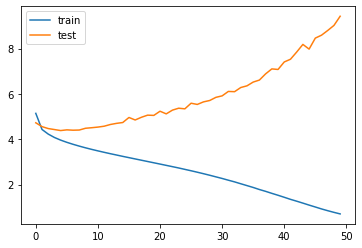

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
predict_sentence("He is good boy")

' आर का तेजी'